In [1]:
import google.generativeai as genai
import os
from dotenv import load_dotenv

load_dotenv()

GEMINI_API_KEY = os.getenv('GEMINI_API_KEY') 
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')

d:\Videos - Cursos\TIME_LATAM\Alvaro\Videos_2255\MULTIAGENTES_LANGGRAPH\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\PC Studio 2\AppData\Local\Temp\ipykernel_22344\393494481.py:1: FutureWarning: 

All support for the `google.generativeai` package has ended. It will no longer be receiving 
updates or bug fixes. Please switch to the `google.genai` package as soon as possible.
See README for more details:

https://github.com/google-gemini/deprecated-generative-ai-python/blob/main/README.md

  import google.generativeai as genai


In [2]:
profile = {
    "name": "Sarah",
    "full_name": "Sarah Chen",
    "user_profile_background": "Ingeniera de software senior liderando un equipo de 5 desarrolladores",
}

In [3]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Newsletters de marketing, e-mails de spam, comunicados generales de la empresa",
        "notify": "Miembro del equipo convaleciente, notificaciones del sistema de build, Actualizaciones del status del proyecto",
        "respond": "Preguntas directas de miembros del equipo, solicitudes de reunión, informes de bugs críticos",
    },
    "agent_instructions": "Usa estas heerramentas cuando sea apropiado para ayudar a gestionar las tareas de Sarah de forma eficiente."
}

In [4]:
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "Sarah Chen <sarah.chen@company.com>",
    "subject": "Duda rápida sobre la documentación de la API",
    "body": """
Hola Sarah,

Estaba revisando la documentación de la API para el nuevo servicio de autenticación y noté que algunos endpoints parecen faltar en las especificaciones. ¿Podrías ayudarme a aclarar si esto fue intencional o si debemos actualizar la documentación?

Específicamente, estoy buscando:
- /auth/refresh
- - /auth/validate

¡Gracias!
Alice""",
}

In [5]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [6]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

In [7]:
class Router(BaseModel): 
    """Analiza el e-mail no leido y enrútalo de acuerdo con su contenido."""

    reasoning: str = Field(
        description="Raciocinio paso a paso tras la clasificación."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="La clasificación de un e-mail: 'ignore' para e-mails irrelevantes, "
        "'notify' para informaciones importantes que no necesitan de una respuesta, "
        "'respond' para e-mails que requieren una respuesta",
    )

In [8]:
llm_router = llm.with_structured_output(Router)

In [9]:
from prompts import triage_system_prompt, triage_user_prompt

In [10]:
system_prompt = triage_system_prompt.format(
    full_name=profile["full_name"],
    name=profile["name"],
    examples=None,
    user_profile_background=profile["user_profile_background"],
    triage_no=prompt_instructions["triage_rules"]["ignore"],
    triage_notify=prompt_instructions["triage_rules"]["notify"],
    triage_email=prompt_instructions["triage_rules"]["respond"],
)

In [11]:
user_prompt = triage_user_prompt.format(
    author=email["from"],
    to=email["to"],
    subject=email["subject"],
    email_thread=email["body"],
)

In [12]:
result = llm_router.invoke(
    [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]
)

In [13]:
print(result)

reasoning='Este correo electrónico es una pregunta directa de un miembro del equipo (Alice Smith) a Sarah Chen solicitando aclaración sobre la documentación de la API. Las reglas establecen que las preguntas directas de los miembros del equipo requieren una respuesta directa de Sarah.' classification='respond'


In [15]:
%pip install -qU langgraph-prebuilt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
from langchain_core.tools import tool

@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Escribe y envía un e-mail."""
    # Respuesta de placeholder - en un aplicativo real, enviaría el e-mail
    return f"E-mail enviado para {to} con el asunto '{subject}'"

In [17]:
@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Programa una reunión en el calendario."""

    return f"Reunión '{subject}' programada para {preferred_day} con {len(attendees)} participantes"

In [18]:
@tool
def check_calendar_availability(day: str) -> str:
    """Verifica la disponibilidad de agenda para una fecha determinada."""

    return f"Horarios disponibles en {day}: 9:00 AM, 2:00 PM, 4:00 PM"

In [19]:
from prompts import agent_system_prompt

def create_prompt(state):
    return [
        {
            "role": "system",
            "content": agent_system_prompt.format(
                instructions=prompt_instructions["agent_instructions"],
                **profile
            )
        }
    ] + state['messages']

In [20]:
print(agent_system_prompt)


< Función >
Eres el/la asistente ejecutivo(a) de {full_name}. Eres un(a) asistente ejecutivo(a) de alto nivel que se preocupa por el desempeño de {name} al máximo posible.
</ Función >

< Herramientas >
Tienes acceso a las siguientes herramientas para ayudar a gestionar las comunicaciones y la agenda de {name}:

1. write_email(to, subject, content) - Envía correos electrónicos a los destinatarios especificados
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Agenda reuniones en el calendario
3. check_calendar_availability(day) - Verifica los horarios disponibles en un día determinado
</ Herramientas >

< Instrucciones >
{instructions}
</ Instrucciones >



In [21]:
from langgraph.prebuilt import create_react_agent

In [22]:
tools=[write_email, schedule_meeting, check_calendar_availability]

In [23]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.5-flash")

agent = create_react_agent(
    model=llm,  
    tools=tools,
    prompt=create_prompt,
)

C:\Users\PC Studio 2\AppData\Local\Temp\ipykernel_22344\2275876398.py:5: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(


In [24]:
response = agent.invoke(
    {"messages": [{
        "role": "user",
        "content": "Cuál es mi disponibilidad para el martes?"
    }]}
)

In [25]:
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

Tu disponibilidad para el martes es: 9:00 AM, 2:00 PM, 4:00 PM.


In [26]:
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [27]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

In [28]:
def triage_router(state: State) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"],
        examples=None
    )
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Clasificación: RESPONDER - Este e-mail requiere una respuesta")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Responde al email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Clasificación: IGNORAR - Este e-mail puede ser ignorado sin problemas")
        update = None
        goto = END
    elif result.classification == "notify":
        # En un escenario real, se realizaría otra acción
        print("🔔 Clasificación: NOTIFICAR - Este e-mail contiene informaciones importantes")
        update = None
        goto = END
    else:
        raise ValueError(f"Clasificación inválida: {result.classification}")
    return Command(goto=goto, update=update)

In [29]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node("triage_router", triage_router)
email_agent = email_agent.add_node("response_agent", agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile()

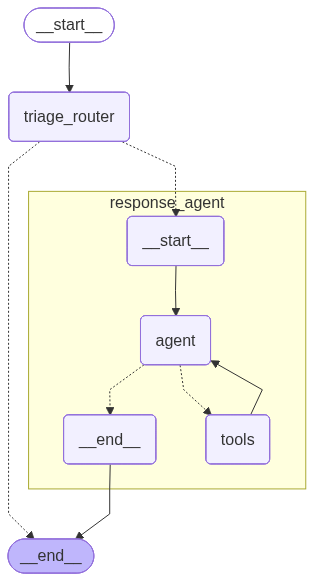

In [30]:
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [31]:
email_input = {
    "author": "Equipo de Marketing <marketing@amazingdeals.com>",
    "to": "Sarah Chen <sarah.chen@company.com>",
    "subject": "🔥 OFERTA EXCLUSIVA: ¡Descuento por Tiempo Limitado en Herramientas para Desarrolladores! 🔥",
    "email_thread": """Estimado(a) Desarrollador(a),

¡No pierda esta oportunidad INCREÍBLE! 

🚀 POR TIEMPO LIMITADO, obtenga un 80% DE DESCUENTO en nuestro Paquete Premium para Desarrolladores. 

✨ RECURSOS:
- Autocompletado de código revolucionario con IA
- Entorno de desarrollo basado en la nube
- Soporte al cliente 24/7
- ¡Y mucho más!

💰 Precio normal: R$ 999/mes
🎉 SU PRECIO ESPECIAL: ¡Solo R$ 199/mes!

🕒 ¡Apúrese! Esta oferta expira en:
¡SOLO 24 HORAS!

Haga clic aquí para canjear su descuento: https://amazingdeals.com/special-offer

Atentamente,
Equipo de Marketing
---
Para cancelar la suscripción, haga clic aquí""",
}

In [32]:
response = email_agent.invoke({"email_input": email_input})

🚫 Clasificación: IGNORAR - Este e-mail puede ser ignorado sin problemas


In [33]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "Sarah Chen <sarah.chen@company.com>",
    "subject": "Consulta rápida sobre la documentación de la API",
    "email_thread": """Hola Sarah,

Estaba revisando la documentación de la API para el nuevo servicio de autenticación y noté que algunos endpoints parecen faltar en las especificaciones. ¿Podrías ayudarme a aclarar si esto fue intencional o si debemos actualizar la documentación?

Específicamente, estoy buscando:
- /auth/refresh
- /auth/validate

¡Gracias!
Alice""",
}

In [34]:
response = email_agent.invoke({"email_input": email_input})

📧 Clasificación: RESPONDER - Este e-mail requiere una respuesta


In [35]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Responde al email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'Sarah Chen <sarah.chen@company.com>', 'subject': 'Consulta rápida sobre la documentación de la API', 'email_thread': 'Hola Sarah,\n\nEstaba revisando la documentación de la API para el nuevo servicio de autenticación y noté que algunos endpoints parecen faltar en las especificaciones. ¿Podrías ayudarme a aclarar si esto fue intencional o si debemos actualizar la documentación?\n\nEspecíficamente, estoy buscando:\n- /auth/refresh\n- /auth/validate\n\n¡Gracias!\nAlice'}
================================== Ai Message ==================================
Tool Calls:
  write_email (65a10bcf-d9bd-4655-9701-fc8f8e6ed3bc)
 Call ID: 65a10bcf-d9bd-4655-9701-fc8f8e6ed3bc
  Args:
    to: Alice Smith <alice.smith@company.com>
    subject: Re: Consulta rápida sobre la documentación de la API
    content: Hola Alice,

Gracias por señalar esto. Sar